In [ ]:
# from sklearn import datasets
# import numpy as np
# X, y1 = datasets.make_circles(n_samples=1000, factor=0.5, noise=0.05)
# import matplotlib.pyplot as plt
# %matplotlib inline
# plt.title('make_circles function example')
# plt.scatter(X[:, 0], X[:, 1], marker='o')
# plt.show()

In [ ]:
import shadow.utils
shadow.utils.set_seed(0, cudnn_deterministic=True)  # set seeds for reproducibility
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import datasets
import numpy as np
n_samples = 1000  # number of samples to generate
noise = 0.1  # noise to add to sample locations
X, y = datasets.make_moons(n_samples=n_samples, noise=noise)

plt.scatter(*X.T, c=y, cmap=plt.cm.Accent)
plt.title("Generated half moons data");

In [ ]:
k=2

def cal_dis(data, clu, k):
    """
    计算质点与数据点的距离
    :param data: 样本点
    :param clu:  质点集合
    :param k: 类别个数
    :return: 质心与样本点距离矩阵
    """
    dis = []
    for i in range(len(data)):
        dis.append([])
        for j in range(k):
            dis[i].append(m.sqrt((data[i, 0] - clu[j, 0])**2 + (data[i, 1]-clu[j, 1])**2))
    return np.asarray(dis)

def divide(data, dis):
    """
    对数据点分组
    :param data: 样本集合
    :param dis: 质心与所有样本的距离
    :param k: 类别个数
    :return: 分割后样本
    """
    clusterRes = [0] * len(data)
    for i in range(len(data)):
        seq = np.argsort(dis[i])
        clusterRes[i] = seq[0]

    return np.asarray(clusterRes)

def center(data, clusterRes, k):
    """
    计算质心
    :param group: 分组后样本
    :param k: 类别个数
    :return: 计算得到的质心
    """
    clunew = []
    for i in range(k):
        # 计算每个组的新质心
        idx = np.where(clusterRes == i)
        sum = data[idx].sum(axis=0)
        avg_sum = sum/len(data[idx])
        clunew.append(avg_sum)
    clunew = np.asarray(clunew)
    return clunew[:, 0: 2]

def classfy(data, clu, k):
    """
    迭代收敛更新质心
    :param data: 样本集合
    :param clu: 质心集合
    :param k: 类别个数
    :return: 误差， 新质心
    """
    clulist = cal_dis(data, clu, k)
    clusterRes = divide(data, clulist)
    clunew = center(data, clusterRes, k)
    err = clunew - clu
    return err, clunew, k, clusterRes
import math as m
import random


def m_kmeans(data, cluster=2):
    k=2
    clu = random.sample(data[:, 0:2].tolist(), 2)  # 随机取质心
    clu = np.asarray(clu)
    err, clunew,  k, clusterRes = classfy(data, clu, 2)
    while np.any(abs(err) > 0):
        print(clunew)
        err, clunew,  k, clusterRes = classfy(data, clunew, 2)
    
    clulist = cal_dis(data, clunew, 2)
    clusterResult = divide(data, clulist)

    return clusterResult

In [ ]:
def myKNN(S, k, sigma=1.0):
    N = len(S)
    A = np.zeros((N,N))

    for i in range(N):
        dist_with_index = zip(S[i], range(N))
        dist_with_index = sorted(dist_with_index, key=lambda x:x[0])
        neighbours_id = [dist_with_index[m][1] for m in range(k+1)] # xi's k nearest neighbours

        for j in neighbours_id: # xj is xi's neighbour
            A[i][j] = np.exp(-S[i][j]/2/sigma/sigma)
            A[j][i] = A[i][j] # mutually

    return A

def calLaplacianMatrix(adjacentMatrix):

    # compute the Degree Matrix: D=sum(A)
    degreeMatrix = np.sum(adjacentMatrix, axis=1)

    # print degreeMatrix

    # compute the Laplacian Matrix: L=D-A
    laplacianMatrix = np.diag(degreeMatrix) - adjacentMatrix

    # print laplacianMatrix

    # normailze
    # D^(-1/2) L D^(-1/2)
    sqrtDegreeMatrix = np.diag(1.0 / (degreeMatrix ** (0.5)))
    return np.dot(np.dot(sqrtDegreeMatrix, laplacianMatrix), sqrtDegreeMatrix)

def euclidDistance(x1, x2, sqrt_flag=False):
    res = np.sum((x1-x2)**2)
    if sqrt_flag:
        res = np.sqrt(res)
    return res

def calEuclidDistanceMatrix(X):
    X = np.array(X)
    S = np.zeros((len(X), len(X)))
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            S[i][j] = 1.0 * euclidDistance(X[i], X[j])
            S[j][i] = S[i][j]
    return S
from itertools import cycle, islice
def plot(X, y_sp, y_km):
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                                '#f781bf', '#a65628', '#984ea3',
                                                '#999999', '#e41a1c', '#dede00']),
                                        int(max(y_km) + 1))))
    plt.subplot(121)
    plt.scatter(X[:,0], X[:,1], s=10, color=colors[y_sp])
    plt.title("Spectral Clustering")
    plt.subplot(122)
    plt.scatter(X[:,0], X[:,1], s=10, color=colors[y_km])
    plt.title("Kmeans Clustering")
    # plt.show()
 

In [ ]:
from sklearn.cluster import KMeans

Similarity = calEuclidDistanceMatrix(X)

Adjacent = myKNN(Similarity, k=5)

Laplacian = calLaplacianMatrix(Adjacent)

x, V = np.linalg.eig(Laplacian)

x = zip(x, range(len(x)))
x = sorted(x, key=lambda x:x[0])

H = np.vstack([V[:,i] for (v, i) in x[:k]]).T

sp_kmeans = m_kmeans(H,cluster=2)
pure_kmeans = KMeans(n_clusters=2).fit(X)

plot(X, sp_kmeans, pure_kmeans.labels_)

c:\Users\xinhu\anaconda3\envs\cpsc6420\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\xinhu\anaconda3\envs\cpsc6420\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


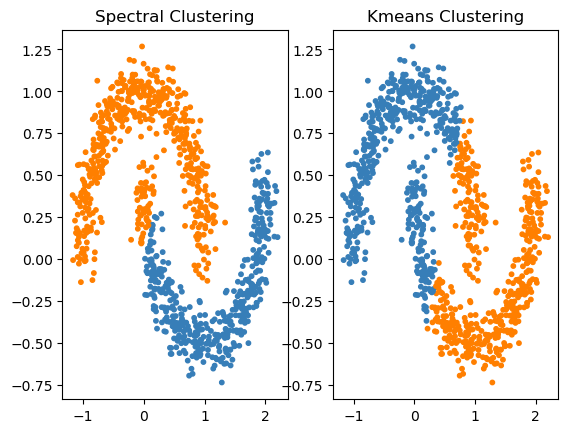

In [8]:
import shadow.utils
shadow.utils.set_seed(0, cudnn_deterministic=True)  # set seeds for reproducibility
#%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import datasets
import numpy as np
import random
import math as m

n_samples = 1000  # number of samples to generate
noise = 0.1  # noise to add to sample locations
X, y = datasets.make_moons(n_samples=n_samples, noise=noise)

class my_kmeans:
    def __init__(self, clusers=2):
        self.k = clusers
        
        #self.clu = random.sample(data[:, 0:2].tolist(), 2)  # 随机取质心

    def cal_dis(self, data, centeroids):
        dis = []
        for i in range(len(data)):
            dis.append([])
            for j in range(self.k):
                dis[i].append(m.sqrt((data[i, 0] - centeroids[j, 0])**2 + (data[i, 1]-centeroids[j, 1])**2))
        return np.asarray(dis)    
    
    def divide(self, data, dis):
        clusterRes = [0] * len(data)
        for i in range(len(data)):
            seq = np.argsort(dis[i])
            clusterRes[i] = seq[0]

        return np.asarray(clusterRes)
    
    def centeroids(self, data, clusterRes):
        centeroids_new = []
        for i in range(self.k):
            idx = np.where(clusterRes == i)
            sum = data[idx].sum(axis=0)
            avg_sum = sum/len(data[idx])
            centeroids_new.append(avg_sum)
        centeroids_new = np.asarray(centeroids_new)
        return centeroids_new[:, 0: 2]
    
    def cluster(self, data, centeroids):
        clulist = self.cal_dis(data, centeroids)
        clusterRes = self.divide(data, clulist)
        centeroids_new = self.centeroids(data, clusterRes)
        err = centeroids_new - centeroids
        return err, centeroids_new, clusterRes
    
    def fit(self,data):
        clu = random.sample(data[:, 0:2].tolist(), 2)  
        clu = np.asarray(clu)
        err, clunew,  clusterRes = self.cluster(data, clu)
        while np.any(abs(err) > 0):
            #print(clunew)
            err, clunew,  clusterRes = self.cluster(data, clunew)

        clulist = self.cal_dis(data, clunew)
        clusterResult = self.divide(data, clulist)

        return clusterResult
    

def myKNN(S, k, sigma=1.0):
    N = len(S)
    A = np.zeros((N,N))

    for i in range(N):
        dist_with_index = zip(S[i], range(N))
        dist_with_index = sorted(dist_with_index, key=lambda x:x[0])
        neighbours_id = [dist_with_index[m][1] for m in range(k+1)] # xi's k nearest neighbours

        for j in neighbours_id: # xj is xi's neighbour
            A[i][j] = np.exp(-S[i][j]/2/sigma/sigma)
            A[j][i] = A[i][j] # mutually

    return A

def calLaplacianMatrix(adjacentMatrix):

    # compute the Degree Matrix: D=sum(A)
    degreeMatrix = np.sum(adjacentMatrix, axis=1)

    # print degreeMatrix

    # compute the Laplacian Matrix: L=D-A
    laplacianMatrix = np.diag(degreeMatrix) - adjacentMatrix

    # print laplacianMatrix

    # normailze
    # D^(-1/2) L D^(-1/2)
    sqrtDegreeMatrix = np.diag(1.0 / (degreeMatrix ** (0.5)))
    return np.dot(np.dot(sqrtDegreeMatrix, laplacianMatrix), sqrtDegreeMatrix)

def euclidDistance(x1, x2, sqrt_flag=False):
    res = np.sum((x1-x2)**2)
    if sqrt_flag:
        res = np.sqrt(res)
    return res

def calEuclidDistanceMatrix(X):
    X = np.array(X)
    S = np.zeros((len(X), len(X)))
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            S[i][j] = 1.0 * euclidDistance(X[i], X[j])
            S[j][i] = S[i][j]
    return S
from itertools import cycle, islice
def plot(X, y_sp, y_km):
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                                '#f781bf', '#a65628', '#984ea3',
                                                '#999999', '#e41a1c', '#dede00']),
                                        int(max(y_km) + 1))))
    plt.subplot(121)
    plt.scatter(X[:,0], X[:,1], s=10, color=colors[y_sp])
    plt.title("Spectral Clustering")
    plt.subplot(122)
    plt.scatter(X[:,0], X[:,1], s=10, color=colors[y_km])
    plt.title("Kmeans Clustering")
    # plt.show()

k=2
from sklearn.cluster import KMeans
Similarity = calEuclidDistanceMatrix(X)
Adjacent = myKNN(Similarity, k=5)
Laplacian = calLaplacianMatrix(Adjacent)
x, V = np.linalg.eig(Laplacian)
x = zip(x, range(len(x)))
x = sorted(x, key=lambda x:x[0])
H = np.vstack([V[:,i] for (v, i) in x[:k]]).T
sp_kmeans = my_kmeans(2).fit(H)
pure_kmeans = KMeans(n_clusters=2).fit(X)
plot(X, sp_kmeans, pure_kmeans.labels_)